In [65]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import pickle
import datetime
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0,os.path.dirname(os.path.dirname(currentdir))) 

from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
from correctData import *
import copy

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
os.path.dirname(parentdir)

'C:\\Users\\hugow\\OneDrive - Fundação para Inovações Tecnológicas - FITec\\Mestrado_PPGES_UPE\\PROJETO\\PVIA_research'

# Load and Process Data

In [3]:
inmet_csv = './historical_data_maceio.csv'
save_scaler = "resultados/MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 30*24

posicao_final=len(df_inmet)-1
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print("data hora inicial: ", df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora,
      "data hora final: ", df_inmet.iloc[posicao_final,:].data,df_inmet.iloc[posicao_final,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
#pickle.dump(MaxAbsScaler_gen, open(save_scaler, 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
data hora inicial:  2020-03-12 20 data ho

# SARIMAX 

## Auto ARIMA

In [8]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-1557.787, Time=10.24 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-717.270, Time=0.79 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1454.105, Time=6.70 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1225.230, Time=6.65 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-711.355, Time=0.25 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-1448.678, Time=10.88 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-1467.922, Time=8.85 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-1559.195, Time=41.63 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-1504.052, Time=37.23 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=46.47 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=-1556.371, Time=42.65 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=-1576.824, Time=35.69 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=9.94 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-1499.356, Time=36.26 sec
 ARIMA(1,0,

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

In [9]:
mod = SARIMAX(endog=gen, exog=exog, order=(1,0,2), seasonal_order=(1,0,2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -1488.858732966085, Mape: 5.3497697460376346


## PSO-ACO Parametrization

In [4]:
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, verbose=False)
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-01-31 22:30:15,939 - root - INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:15,939: INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:16,040 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,040: INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,048 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,048: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,052 - root - INFO - 5
2021-01-31 22:30:16,052: INFO - 5
2021-01-31 22:30:16,201 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.glob

In [90]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,0,0,0]], order=(2,0,0), seasonal_order=(1,0,1, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -1519.18991387265, Mape: 6.56084020712168


### SARIMAX 1 day AHEAD

In [104]:
# nesse caso, para usar o get_forecast é preciso ter também as variáveis exógenas do dia da frente, apenas para teste
# vou deixar as mesmas do dia anterior
y_sarimax_ahead = results.get_forecast(24, exog=exog[-24:,[1,0,0,0]]).predicted_mean

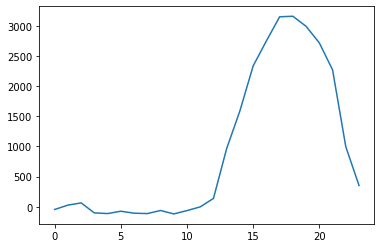

In [111]:
plt.plot(MaxAbsScaler_gen.inverse_transform(y_sarimax_ahead[-24:].reshape(-1,1)))

## DUMP Sarimax

In [19]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

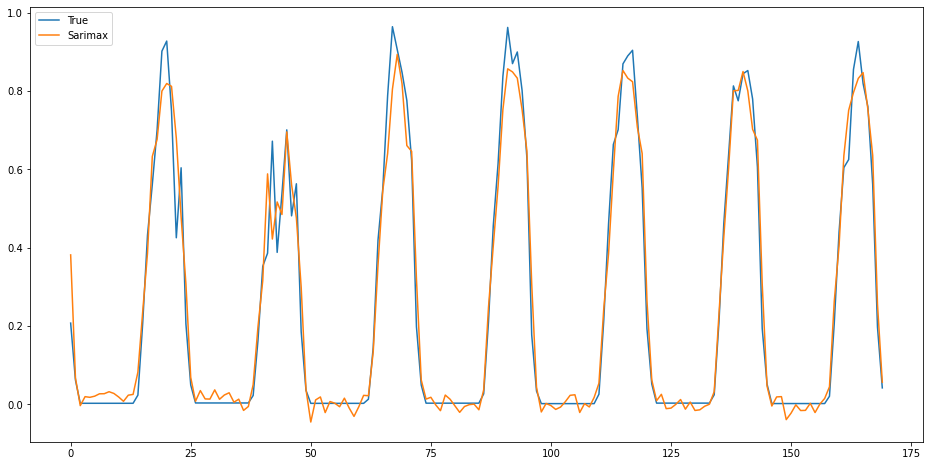

In [11]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [22]:
# ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12, prob_mut=0.8,
#                                  tr_ts_percents=tr_ts_percents).search_best_model()
# best_mlp_residual = ag_mlp_residual._best_of_all
#pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]generation: 0

100%|██████████| 3/3 [00:21<00:00,  7.06s/it]

100%|██████████| 3/3 [00:33<00:00, 11.09s/it]

100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

100%|██████████| 3/3 [00:50<00:00, 16.92s/it]

100%|██████████| 3/3 [00:12<00:00,  4.09s/it]

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]

100%|██████████| 3/3 [00:28<00:00,  9.47s/it]

100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

100%|██████████| 3/3 [00:10<00:00,  3.33s/it]

100%|██████████| 3/3 [00:54<00:00, 18.04s/it]

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

100%|██████████| 3/3 [00:40<00:00, 13.44s/it]

100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

100%|██████████| 3/3 [00:41<00:00, 13.71s/it]

100%|██████████| 3/3 [00:15<00:00,  5.13s/it]

100%|██████████| 3/3 [00:40<00:00, 13.65s/it]

100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

100%|██████████| 3/3 [00:56<00:00, 18.98s/it]

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

100%|██████████| 3/3 [00:49<00:00, 16.64s/it]

100%|███

## Results

[17, 19, 3, 16, MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(68, 44, 5), max_iter=500), MLPRegressor(early_stopping=True, hidden_layer_sizes=(18, 12, 8),
             learning_rate='adaptive', max_iter=500, solver='lbfgs'), 0.02432105552993146]
Teste para saber se pegou o melhor mesmo! 0.02432105552993146 == 0.02432105552993146 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  2.9130356221922984
HIBRIDO
MAE:  0.02432105552993146
MSE:  0.0018577701507670231
MAPE:  0.9090129264241438
GANHO MAE:
0.3094881465536412
GANHO MSE:
0.3683526750329882
GANHO MAPE:
0.6879499448963013


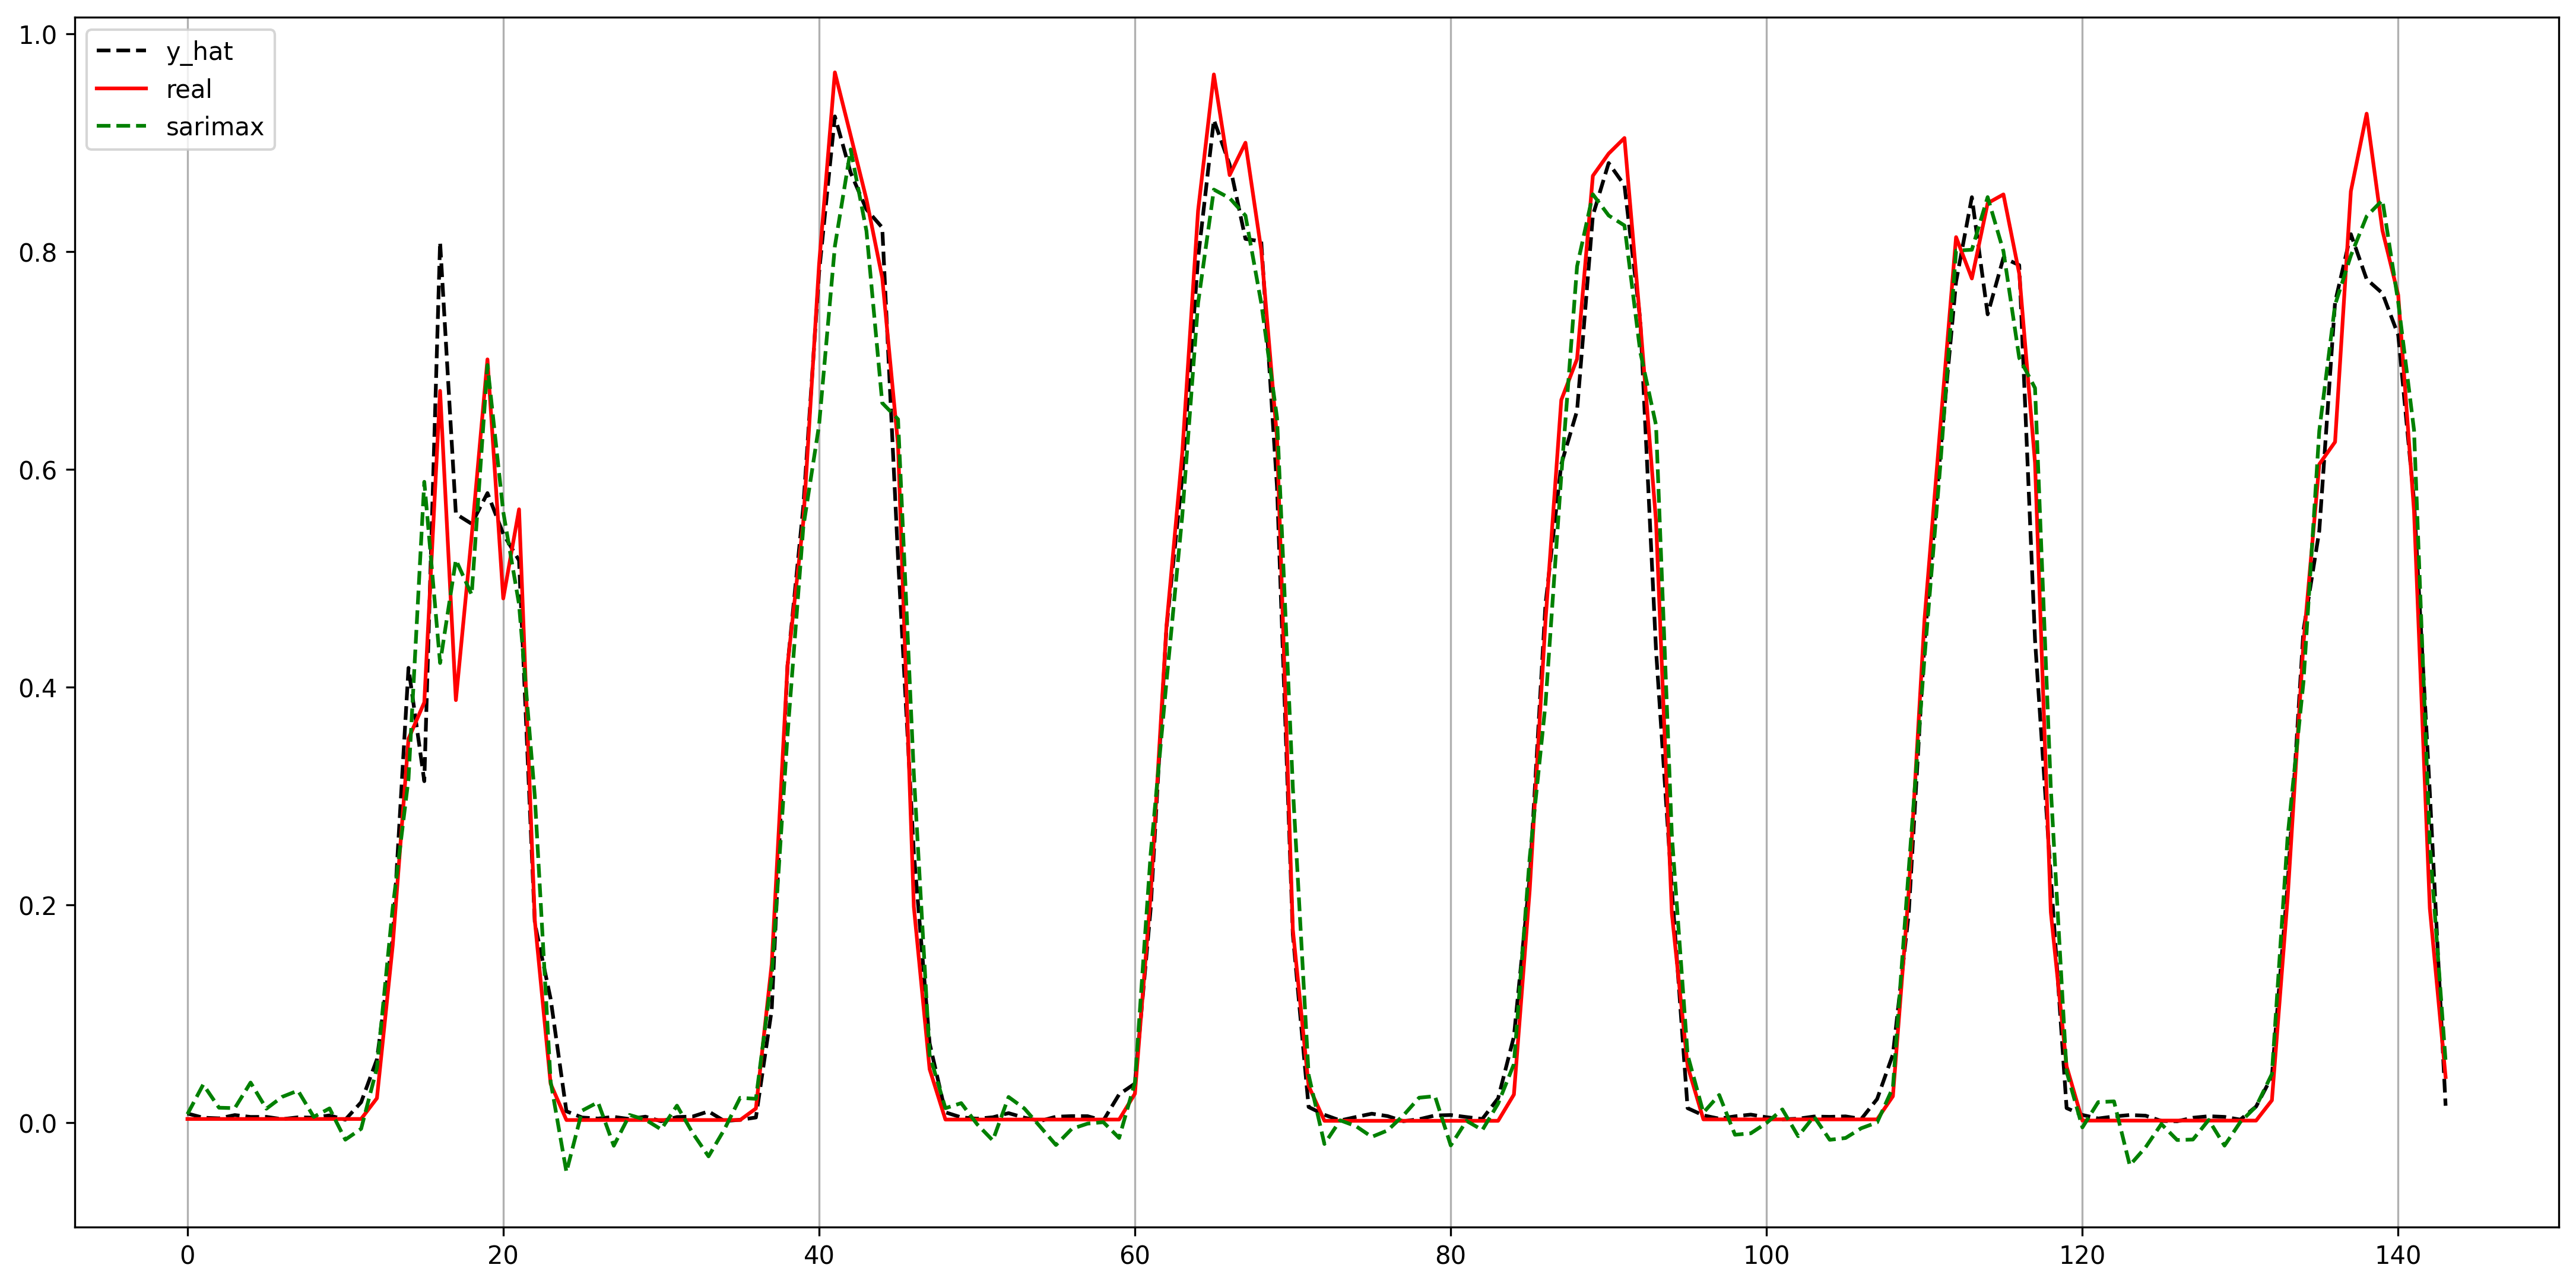

In [12]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

tr_ts_percents=[80,20]

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

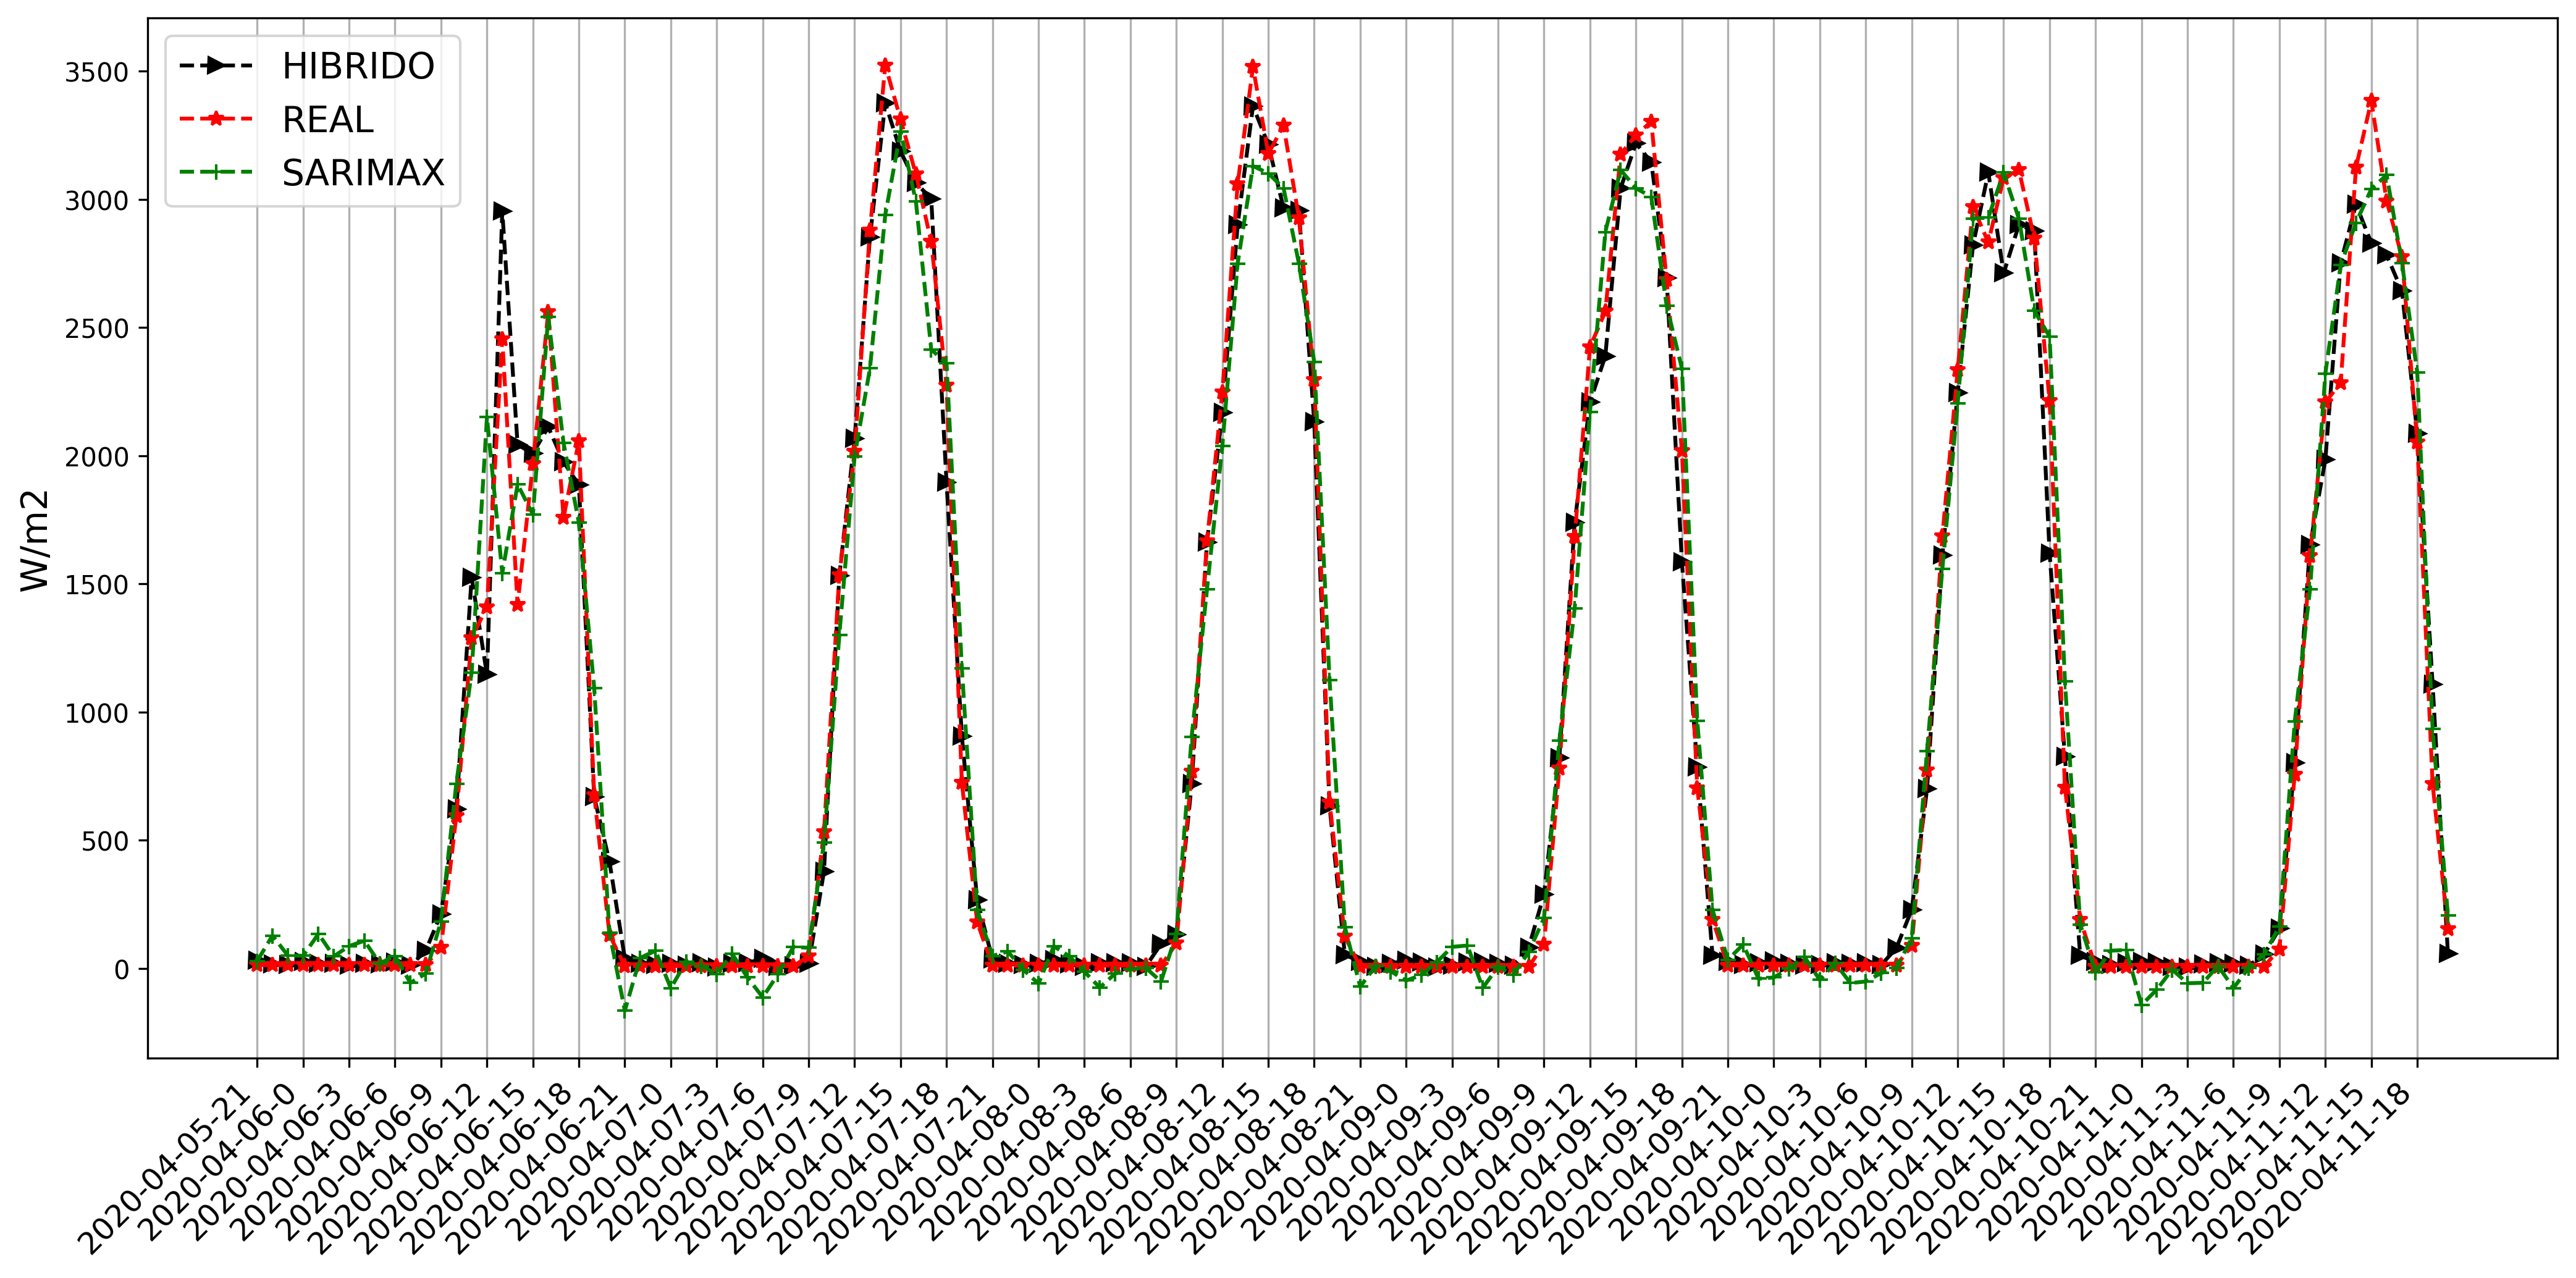

In [39]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=14)
ax.set_ylabel('W/m2', fontsize=14)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch3_pop12.png', dpi=300)

## 1 day ahead forecast

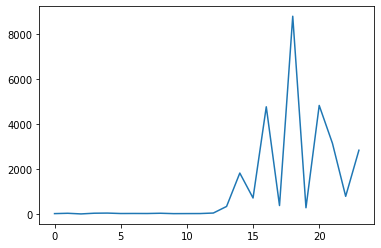

In [112]:
# aqui é um exemplo de como fazer 1 day ahead forecast com base no algoritmo
# esse exemplo é importante pq da para ver que tem como implementar. Porém 1 day ahead é muita coisa, visto
# que são usados dados horários, então obiviamente o resultado não é bom.

erro = gen - y_sarimax

gen_day_ahead = gen.copy()
y_sarimax_day_ahead = y_sarimax.copy()

for i in range(24):
    
    erro_day_ahead = gen_day_ahead - y_sarimax_day_ahead

    erro_estimado_for_forecast = best[4].predict(erro_day_ahead[-best[0]:].reshape(1,-1))

    erro_fut = erro_day_ahead.copy()
    for _ in range(best[3]):
        erro_fut = np.append(erro_day_ahead, best[4].predict(erro_fut[-best[0]:].reshape(1,-1)))

    X_ass_1_forecast_in = y_sarimax_day_ahead[-best[1]-1:]
    X_ass_2_forecast_in = np.concatenate((erro_estimado_for_forecast[-best[2]-1:], erro_fut[-best[3]-1:]))

    X_in_forecast = np.concatenate((X_ass_1_forecast_in, X_ass_2_forecast_in))

    y_forecast = best[5].predict(X_in_forecast.reshape(1,-1))

    gen_day_ahead = np.append(gen_day_ahead, y_forecast)
    y_sarimax_day_ahead = np.append(y_sarimax_day_ahead, y_sarimax_ahead[i])
    
plt.plot(MaxAbsScaler_gen.inverse_transform(gen_day_ahead[-24:].reshape(-1,1)))

# Algoritmo AGMLP_VR_Residual

In [113]:
tr_ts_percents=[80,20]

## Train

In [26]:
# ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12,
#                                        prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

# best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

# pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0
  0%|          | 0/3 [00:00<?, ?it/s]generation: 0
start_set_fit: 0

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

100%|██████████| 3/3 [00:53<00:00, 17.69s/it]

100%|██████████| 3/3 [00:11<00:00,  3.90s/it]

100%|██████████| 3/3 [00:28<00:00,  9.37s/it]

100%|██████████| 3/3 [00:11<00:00,  3.84s/it]

100%|██████████| 3/3 [00:43<00:00, 14.42s/it]

100%|██████████| 3/3 [00:20<00:00,  6.99s/it]

100%|██████████| 3/3 [00:32<00:00, 10.83s/it]

100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

100%|██████████| 3/3 [00:41<00:00, 13.72s/it]

100%|██████████| 3/3 [00:15<00:00,  5.08s/it]

100%|██████████| 3/3 [00:32<00:00, 10.71s/it]

100%|██████████| 3/3 [00:07<00:00,  2.60s/it]

100%|██████████| 3/3 [00:42<00:00, 14.27s/it]

100%|██████████| 3/3 [00:20<00:00,  6.97s/it]

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

100%|██████████| 3/3 [00:13<00:00,  4.55s/it]

100%|██████████| 3/3 [00:27<00:00,  9.16s/it]

100%|██████████| 3/3 [00:30<00:00, 10.29s/it]

100%|██████████| 3/3 

## Results

[16, 16, 4, 16, 20, <mlopt.AgMlp.AgMlp object at 0x000001B718FE2B20>, <mlopt.AgMlp.AgMlp object at 0x000001B7142EDF40>, 0.026848473486150163]
Teste para saber se pegou o melhor mesmo! 0.026848473486150257 == <mlopt.AgMlp.AgMlp object at 0x000001B7142EDF40> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  2.9130356221922984
HIBRIDO
MAE:  0.026848473486150257
MSE:  0.0024394409996036518
MAPE:  0.5304537873955737
GANHO MAE:
0.23773089674043102
GANHO MSE:
0.17058287260223348
GANHO MAPE:
0.8179034326410455


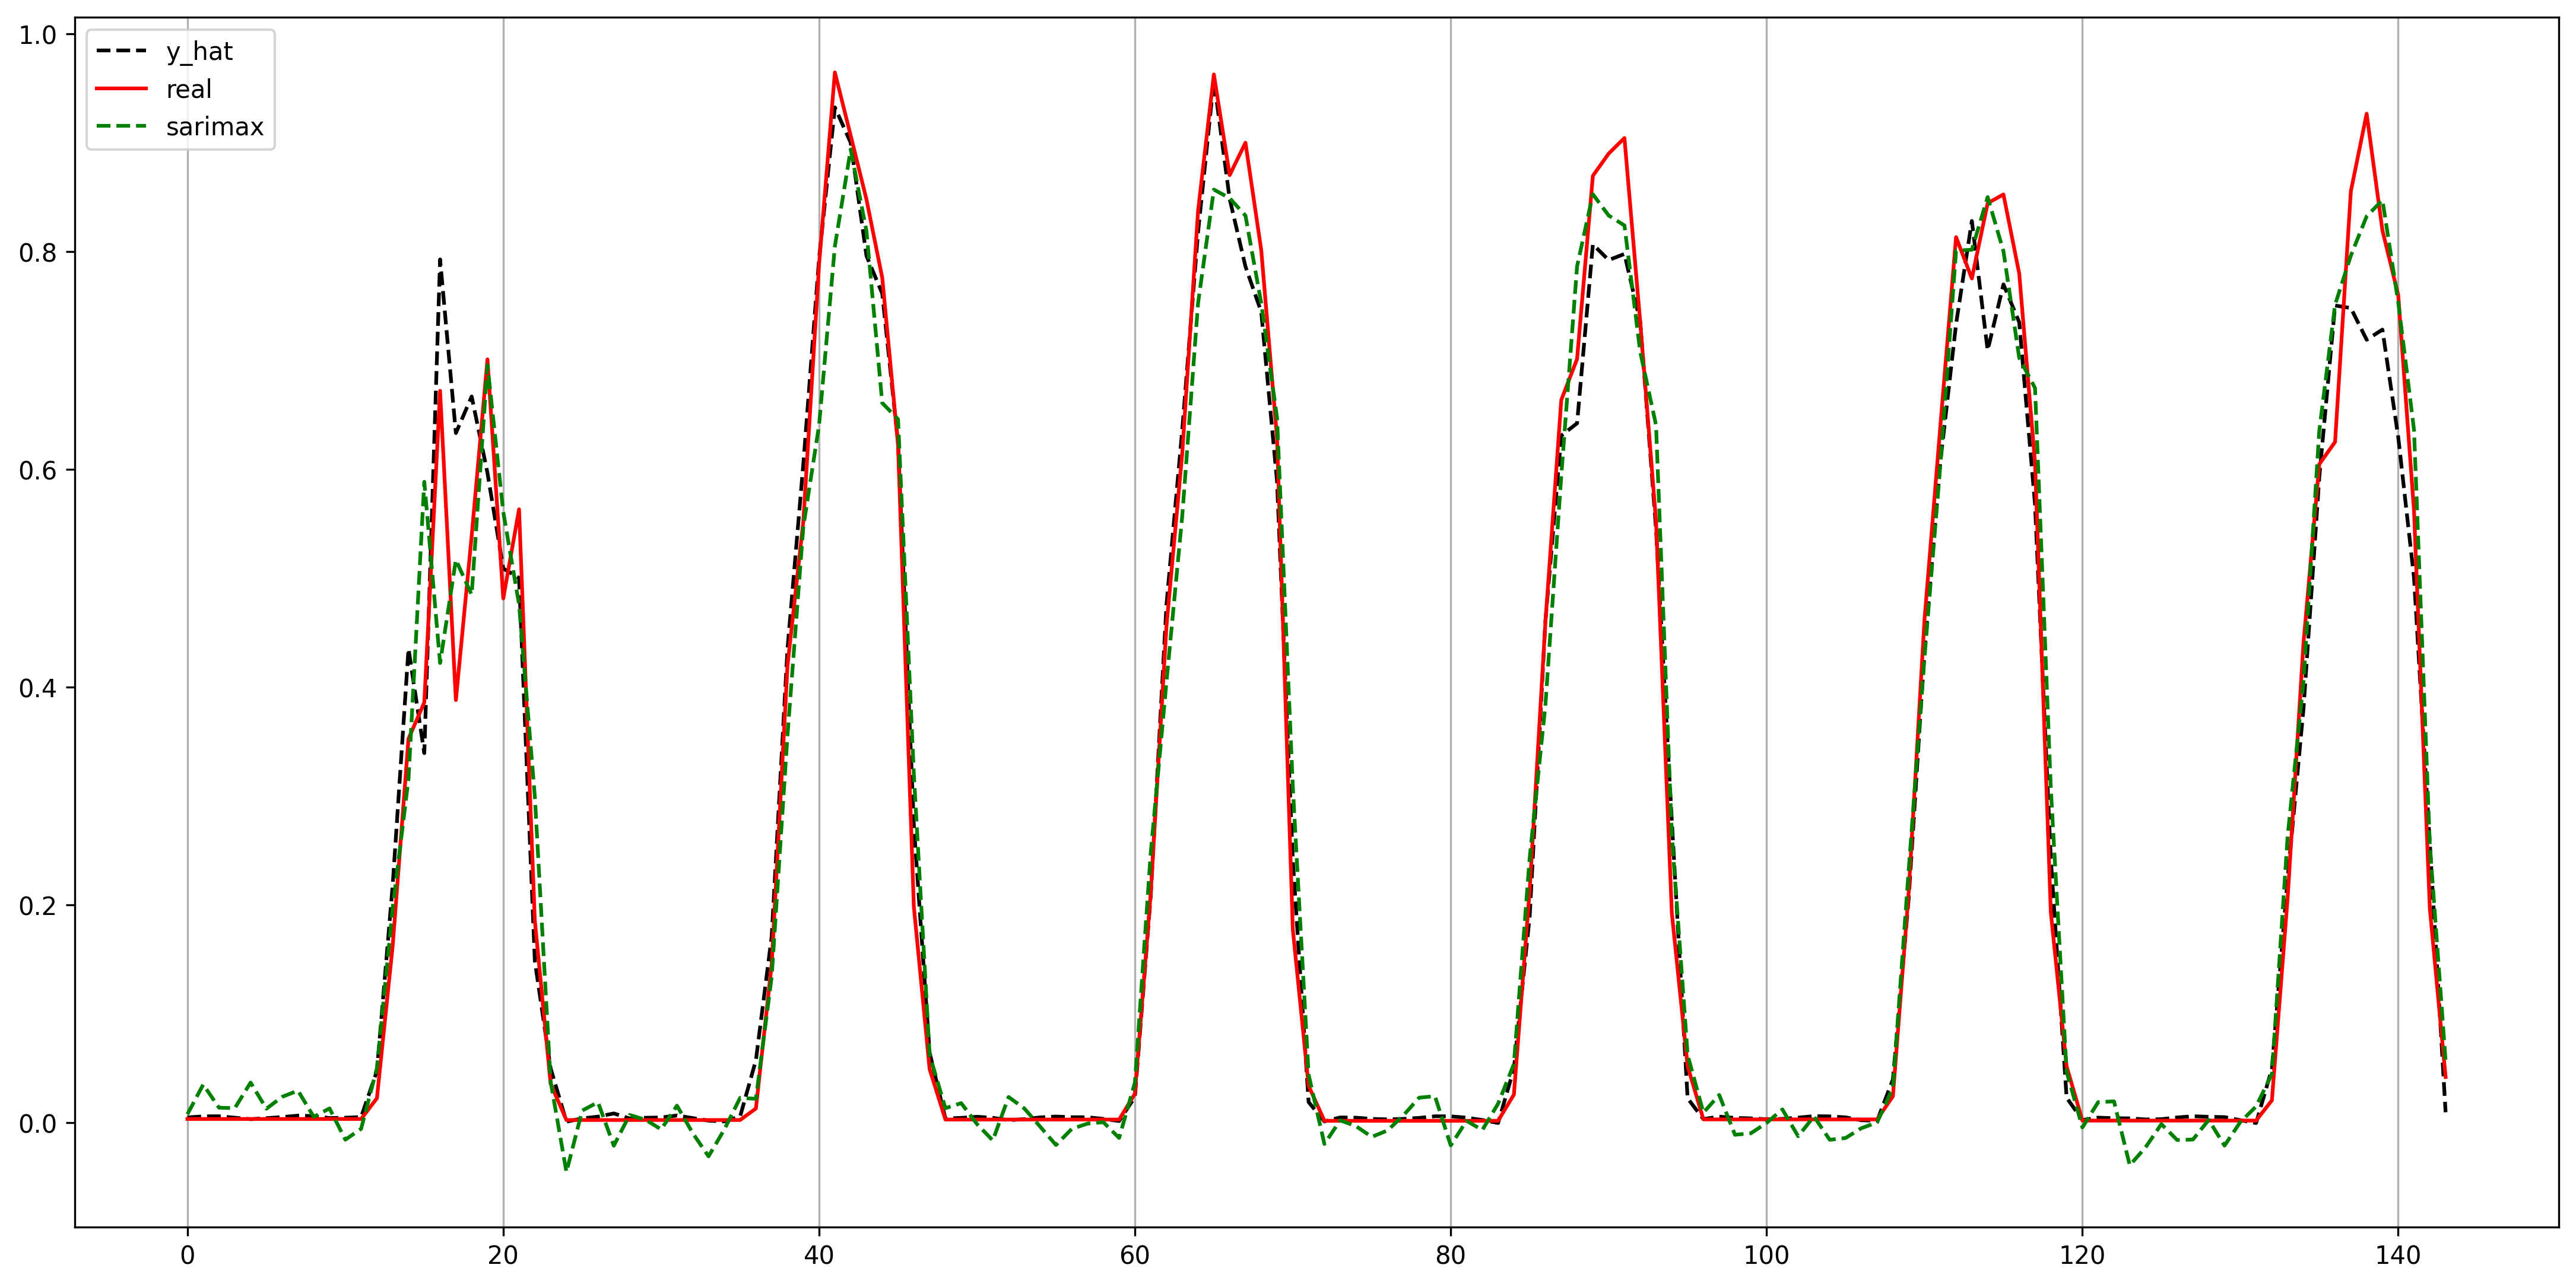

In [13]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

tr_ts_percents=[80,20]

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

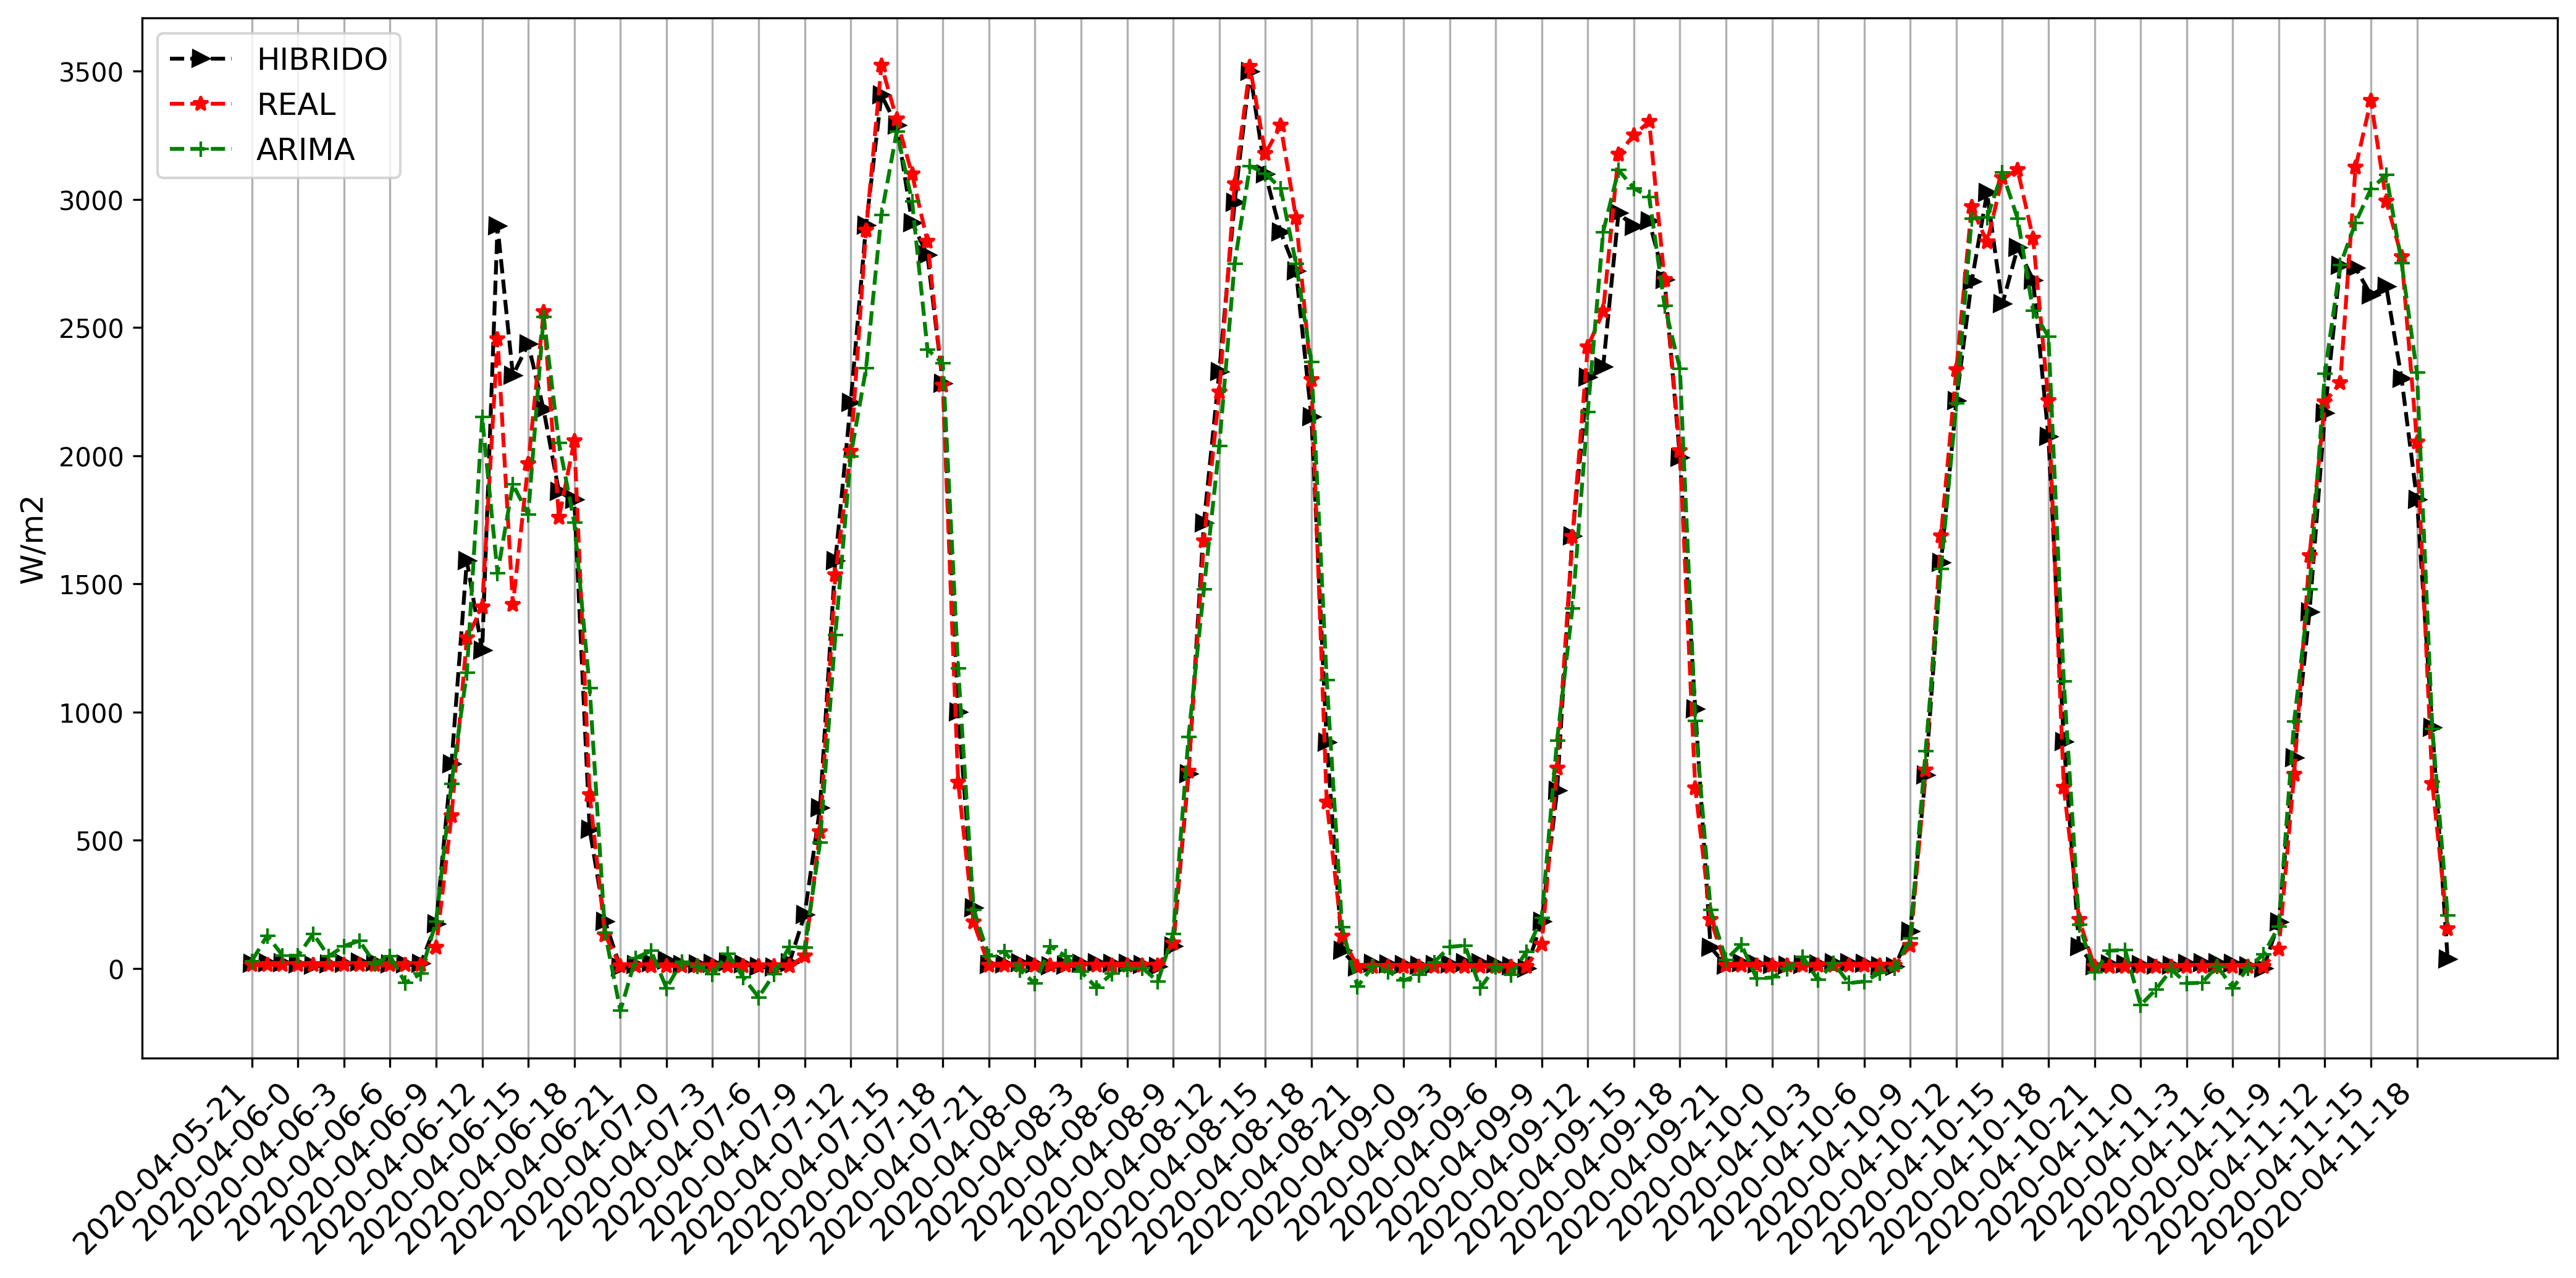

In [45]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpvrresidual_epoch3_pop12.png', dpi=300)

# LSTM + MLP

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

## Train

In [44]:
from mlopt.ACOLSTM import ACOLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':2, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


In [32]:
lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, 1,
                        options_ACO=options_ACO)

final_model, y_hat = lstmOptimizer.optimize(searchSpace)

100%|██████████| 1/1 [04:55<00:00, 295.29s/it]


ACO-All Best Response: [70  2 40  5 15  1  2  2]. Fitness: 0.03255305817764589


In [35]:
final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-27 19:39:08,507 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-27 19:39:08,507: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [14]:
from tensorflow import keras

_, _, X_test_lstm, y_test_lstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_hat_lstm, y_test_lstm))
print('MSE: ', mse(y_hat_lstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm))

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


2021-05-25 22:23:38,522 - tensorflow - WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-05-25 22:23:38,522: WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-05-25 22:23:38,847 - tensorflow - WARNING - Layer lstm_110 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-25 22:23:38,847: WARNING - Layer lstm_110 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback w

Resultado Dados Teste!
LSTM
MAE:  0.03130132257164395
MSE:  0.003829827462892584
MAPE:  0.6248604859754197


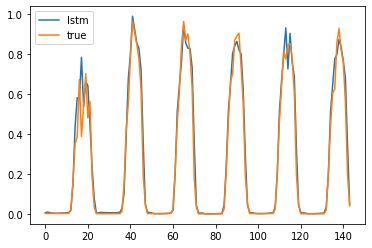

In [49]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

# CLSTM

## Train

In [76]:
from mlopt.ACOLSTM import ACOCLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':1, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


In [80]:
Layers_Qtd=[[50, 30, 20, 10], [20, 15, 10], [10, 20], [30, 20], [10, 5]]
ConvKernels=[[8, 12], [4, 6]]
epochs=[200]

clstmOptimizer = ACOCLSTM(X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm,
                          1 ,options_ACO=options_ACO, verbose=True)

final_model, y_hat_clstm = clstmOptimizer.optimize(Layers_Qtd = Layers_Qtd, ConvKernels = ConvKernels, epochs=epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[50, 30, 20, 10], [8, 12], [20, 15, 10], [4, 6], [10, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [30, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [10, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0]]
Space Created:  [[50  8 20 ...  0  0  0]
 [50  8 20 ...  0  1  0]
 [50  8 20 ...  0  2  0]
 ...
 [10 12 10 ...  5  1  0]
 [10 12 10 ...  5  2  0]
 [10 12 10 ...  5  3  0]]
number of Space Possibilities (rows):  11943936
Setting fitness for
[10 12 15  4 20  5  5 20  0  1  5  1  2  0]


2021-05-26 01:04:47,636 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:04:47,636: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:04:47,636: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:04:47,685 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:04:47,685: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:04:47,685: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't m

{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'sigmoid', 'fl_refunc': 'sigmoid', 'sl_qtn': 20, 'sl_func': 'elu', 'sl_refunc': 'selu', 'tl_qtn': 5, 'tl_func': 'selu', 'optimizer': 'rmsprop'}
Epoch 1/200
18/18 [==============================] - 45s 219ms/step - loss: 0.5272 - mse: 0.5703
Epoch 2/200
18/18 [==============================] - 2s 115ms/step - loss: 0.3003 - mse: 0.1367
Epoch 3/200
18/18 [==============================] - 2s 116ms/step - loss: 0.2153 - mse: 0.0707
Epoch 4/200
18/18 [==============================] - 2s 104ms/step - loss: 0.2051 - mse: 0.0628
Epoch 5/200
18/18 [==============================] - 2s 107ms/step - loss: 0.1693 - mse: 0.0461
Epoch 6/200
18/18 [==============================] - 2s 111ms/step - loss: 0.1785 - mse: 0.0453
Epoch 7/200
18/18 [==============================] - 2s 106ms/step - loss: 0.1373 - mse: 0.0322
Epoch 8/200
18/18 [==============================] - 2

18/18 [==============================] - 2s 126ms/step - loss: 0.0391 - mse: 0.0066
Epoch 166/200
18/18 [==============================] - 2s 130ms/step - loss: 0.0434 - mse: 0.0074
Epoch 167/200
18/18 [==============================] - 3s 138ms/step - loss: 0.0377 - mse: 0.0066
Epoch 168/200
18/18 [==============================] - 2s 137ms/step - loss: 0.0386 - mse: 0.0058
Epoch 169/200
18/18 [==============================] - 2s 124ms/step - loss: 0.0390 - mse: 0.0060
Epoch 170/200
18/18 [==============================] - 2s 124ms/step - loss: 0.0422 - mse: 0.0073
Epoch 171/200
18/18 [==============================] - 2s 126ms/step - loss: 0.0410 - mse: 0.0073
Epoch 172/200
18/18 [==============================] - 2s 132ms/step - loss: 0.0404 - mse: 0.0072
Epoch 173/200
18/18 [==============================] - 2s 125ms/step - loss: 0.0405 - mse: 0.0064
Epoch 174/200
18/18 [==============================] - 2s 125ms/step - loss: 0.0411 - mse: 0.0070
Epoch 175/200
18/18 [=============

2021-05-26 01:14:03,811 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:14:03,811: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:14:03,811: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:14:03,830 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:14:03,830: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:14:03,830: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't m

SHAPES output hat: (144,) and test: (144,)
fitness is
0.040044077267348356
Setting fitness for
[10 12 20  4 10  1  3 20  3  1  5  5  0  0]
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'selu', 'fl_refunc': 'relu', 'sl_qtn': 20, 'sl_func': 'relu', 'sl_refunc': 'selu', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}
Epoch 1/200
18/18 [==============================] - 8s 118ms/step - loss: nan - mse: nan
Epoch 2/200
18/18 [==============================] - 2s 130ms/step - loss: nan - mse: nan
Epoch 3/200
18/18 [==============================] - 2s 135ms/step - loss: nan - mse: nan
Epoch 4/200
18/18 [==============================] - 2s 135ms/step - loss: nan - mse: nan
Epoch 5/200
18/18 [==============================] - 2s 131ms/step - loss: nan - mse: nan
Epoch 6/200
18/18 [==============================] - 2s 135ms/step - loss: nan - mse: nan
Epoch 7/200
18/18 [==============================] - 2

18/18 [==============================] - 2s 125ms/step - loss: nan - mse: nan
Epoch 176/200
18/18 [==============================] - 2s 128ms/step - loss: nan - mse: nan
Epoch 177/200
18/18 [==============================] - 2s 127ms/step - loss: nan - mse: nan
Epoch 178/200
18/18 [==============================] - 2s 127ms/step - loss: nan - mse: nan
Epoch 179/200
18/18 [==============================] - 2s 137ms/step - loss: nan - mse: nan
Epoch 180/200
18/18 [==============================] - 2s 126ms/step - loss: nan - mse: nan
Epoch 181/200
18/18 [==============================] - 2s 125ms/step - loss: nan - mse: nan
Epoch 182/200
18/18 [==============================] - 2s 123ms/step - loss: nan - mse: nan
Epoch 183/200
18/18 [==============================] - 2s 122ms/step - loss: nan - mse: nan
Epoch 184/200
18/18 [==============================] - 2s 118ms/step - loss: nan - mse: nan
Epoch 185/200
18/18 [==============================] - 2s 118ms/step - loss: nan - mse: nan
Ep

100%|██████████| 1/1 [17:49<00:00, 1069.26s/it]
2021-05-26 01:22:34,460 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:22:34,460: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:22:34,460: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:22:34,467 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:22:34,467: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:22:34,467: WARNING - Layer lstm

Pij:
[[4.4473754e-07]
 [8.8947509e-08]
 [8.8947509e-08]
 ...
 [8.8947509e-08]
 [8.8947509e-08]
 [8.8947509e-08]]
Ant 0 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 0 move from 11195790 to 2823659
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[2.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
Pij:
[[4.4473754e-07]
 [8.8947509e-08]
 [8.8947509e-08]
 ...
 [8.8947509e-08]
 [8.8947509e-08]
 [8.8947509e-08]]
Ants now - then
[2823659] - [11195790]
ACO-All Best Response: [10 12 15  4 20  5  5 20  0  1  5  1  2  0]. Fitness: 0.040044077267348356
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'sigmoid', 'fl_refunc': 'sigmoid', 'sl_qtn': 20, 'sl_func': 'elu', 'sl_refunc': 'selu', 'tl_qtn': 5, 'tl_func': 'selu', 'optimizer': 'rmsprop'}
Epoch 1/200
18/18 [==============================] - 9s 131ms/step - loss: 0.4885 - mse: 0.4046
Epoch 2/200
18/18 [==============================

Epoch 160/200
18/18 [==============================] - 2s 139ms/step - loss: 0.0395 - mse: 0.0061
Epoch 161/200
18/18 [==============================] - 3s 141ms/step - loss: 0.0414 - mse: 0.0067
Epoch 162/200
18/18 [==============================] - 3s 156ms/step - loss: 0.0390 - mse: 0.0060
Epoch 163/200
18/18 [==============================] - 2s 130ms/step - loss: 0.0435 - mse: 0.0066
Epoch 164/200
18/18 [==============================] - 3s 148ms/step - loss: 0.0392 - mse: 0.0062
Epoch 165/200
18/18 [==============================] - 2s 120ms/step - loss: 0.0419 - mse: 0.0065
Epoch 166/200
18/18 [==============================] - 2s 128ms/step - loss: 0.0406 - mse: 0.0067
Epoch 167/200
18/18 [==============================] - 2s 123ms/step - loss: 0.0422 - mse: 0.0068
Epoch 168/200
18/18 [==============================] - 2s 138ms/step - loss: 0.0384 - mse: 0.0063
Epoch 169/200
18/18 [==============================] - 2s 134ms/step - loss: 0.0400 - mse: 0.0062
Epoch 170/200
18/18 

In [81]:
print("SHAPE y_hat_clstm", y_hat_clstm.shape)

print('Resultado Dados Teste!')
print('CLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_lstm))
print('MSE: ', mse(y_hat_clstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_clstm[:], y_test_lstm))

SHAPE y_hat_clstm (144,)
Resultado Dados Teste!
CLSTM
MAE:  0.058208827768877085
MSE:  0.0096567363522633
MAPE:  1.0956222438388463


In [82]:
final_model.save('./resultados/clstm_model')

2021-05-26 01:31:00,499 - tensorflow - INFO - Assets written to: ./resultados/clstm_model\assets
2021-05-26 01:31:00,499: INFO - Assets written to: ./resultados/clstm_model\assets
2021-05-26 01:31:00,499: INFO - Assets written to: ./resultados/clstm_model\assets


## Results

In [85]:
from tensorflow import keras

loadedmodel = keras.models.load_model('./resultados/clstm_model')
_, _, X_test_clstm, y_test_clstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
y_hat_clstm = loadedmodel.predict(X_test_clstm.reshape((X_test_clstm.shape[0], X_test_clstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('cLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_clstm))
print('MSE: ', mse(y_hat_clstm, y_test_clstm))
print('MAPE: ', MAPE(y_hat_clstm, y_test_clstm))

2021-05-26 01:31:47,650 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:31:47,650: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:31:47,650: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:31:47,673 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:31:47,673: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:31:47,673: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't m

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)
Resultado Dados Teste!
cLSTM
MAE:  0.058208827768877085
MSE:  0.0096567363522633
MAPE:  1.0956222438388463


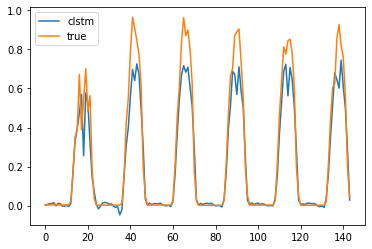

In [86]:
plt.plot(y_hat_clstm[:,0], label='clstm')
plt.plot(y_test_clstm, label='true')
plt.legend()

# Figura Unica

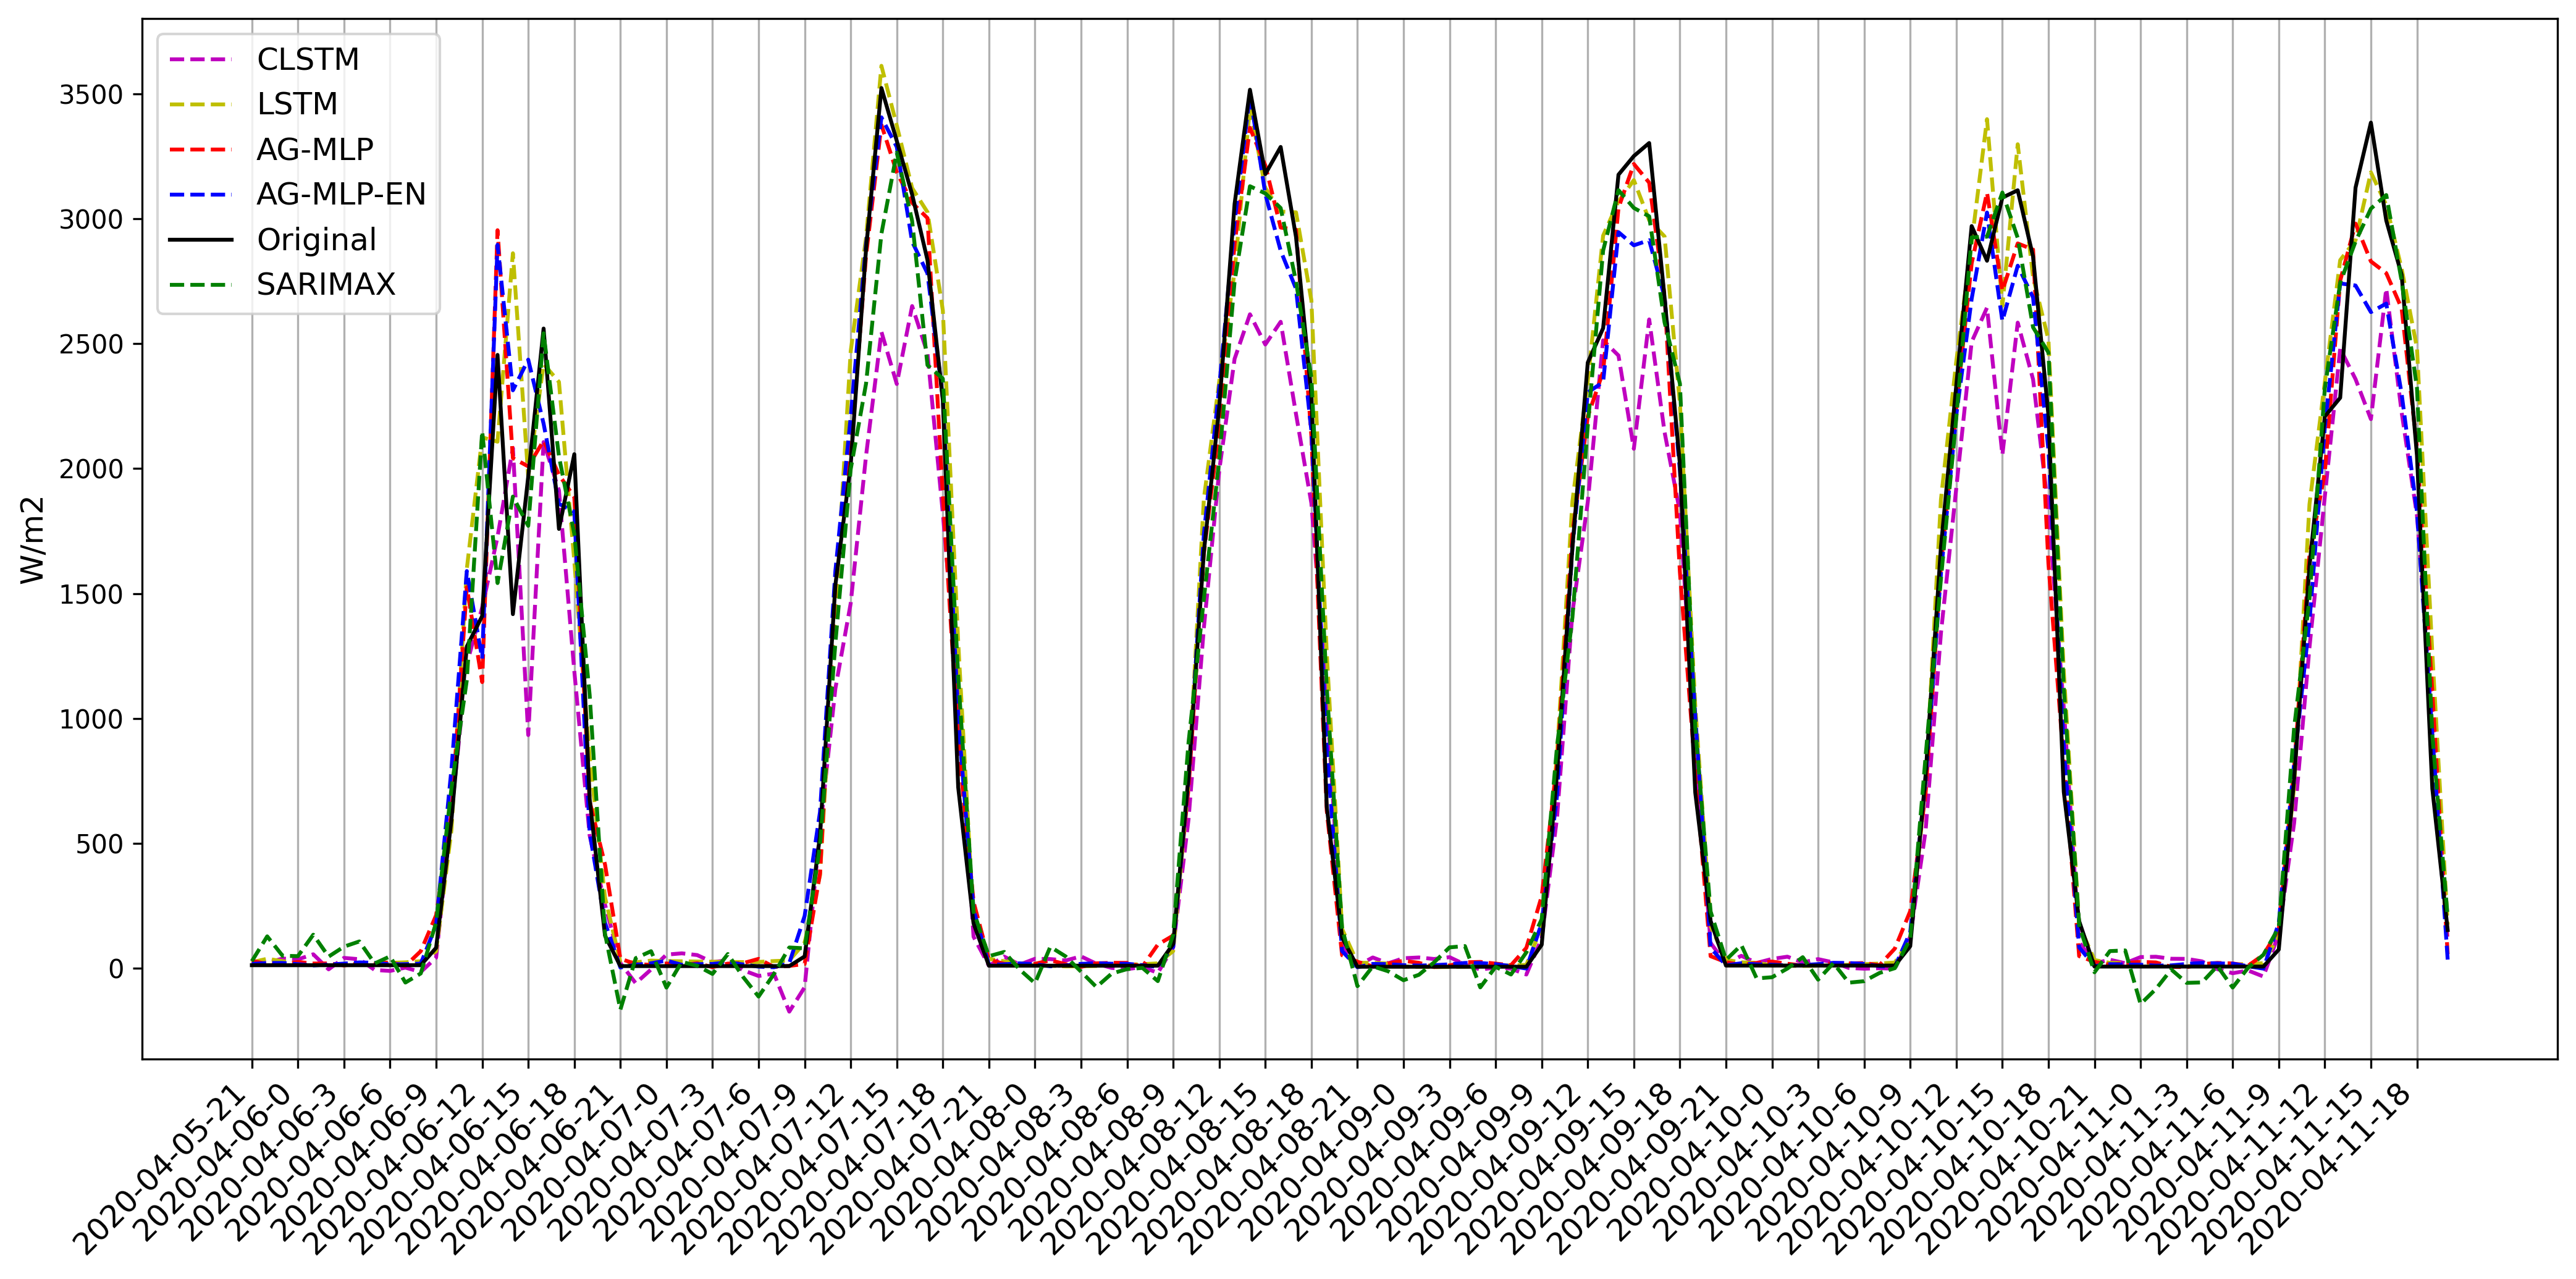

In [87]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_clstm[-len_dt:].reshape(-1, 1)), 'm--', label='CLSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), 'y--', label='LSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-len_dt:].reshape(-1, 1)), 'r--', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-len_dt:].reshape(-1, 1)),
        'b--', label='AG-MLP-EN')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Original')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids_new.png', dpi=300)